# Synthetic Features and Outliers

This colab continues the linear regression model started in the previous exercise. In this exercise, we'll try new features and study the effect of outliers in the input data.

The code in the cells below is identical to the one in the previous section.

In [0]:
#@test {"output": "ignore"}

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import google3
import tensorflow.google as tf
from IPython import display
from google3.pyglib import gfile
from matplotlib import cm
from matplotlib import gridspec
from numpy import linspace
from sklearn import metrics

# Set the output display to have one digit for decimal places, for display
# readability only.
pd.options.display.float_format = '{:.1f}'.format

# Load in the data from CSV files.
california_housing_dataframe = pd.read_csv(
  gfile.Open("/placer/prod/home/ami/mlcc/california_housing/v1/train.csv"),
  sep=",")
# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient Descent.
california_housing_dataframe = california_housing_dataframe.reindex(
  np.random.permutation(california_housing_dataframe.index))
print "Data set loaded and randomized.\n"

# Pick out the columns we care about for this exercise.
california_housing_dataframe = california_housing_dataframe[
  ["totalRooms", "population", "medianHouseValue"]]
# Scale the medianHouseValue to be in units of thousands, so it can be learned a
# little more easily with learning rates in a range that we usually use.
california_housing_dataframe["medianHouseValue"] = (
  california_housing_dataframe["medianHouseValue"] / 1000.0)

# Print out some entries in the data set so we can see what we're dealing with.
print "The first few entries in the data set are:"
display.display(california_housing_dataframe.head())

print "\nSummary of the data set:"
display.display(california_housing_dataframe.describe())

Data set loaded and randomized.

The first few entries in the data set are:


,totalRooms,population,medianHouseValue
4747,3260.0,1969.0,215.5
11661,1630.0,4402.0,63.0
6227,1772.0,1122.0,96.1
7421,1028.0,1369.0,144.6
11322,1528.0,729.0,138.8



Summary of the data set:


,totalRooms,population,medianHouseValue
count,17000.0,17000.0,17000.0
mean,2643.7,1429.6,207.3
std,2179.9,1147.9,116.0
min,2.0,3.0,15.0
25%,1462.0,790.0,119.4
50%,2127.0,1167.0,180.4
75%,3151.2,1721.0,265.0
max,37937.0,35682.0,500.0


### Task 1: Try a synthetic feature.

Both the `totalRooms` and `population` features count totals for a given city block.

But what if one city block were more densely populated than another?

We can get at this idea by creating a synthetic feature that's a ratio of our two source features.

Create a feature called `roomsPerPerson`, and use that as an input in the model code cell below.

What is the best performance you can get with this single feature?


Training model...
RMSE (on training data):
  period 00 : 203.20
  period 01 : 178.73
  period 02 : 159.55
  period 03 : 146.39
  period 04 : 139.57
  period 05 : 137.33
  period 06 : 137.22
  period 07 : 137.77
  period 08 : 138.33
  period 09 : 138.72
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,205.3,207.3
std,76.2,116.0
min,77.4,15.0
25%,175.4,119.4
50%,202.7,180.4
75%,225.9,265.0
max,3674.9,500.0


Final RMSE (on training data): 138.72


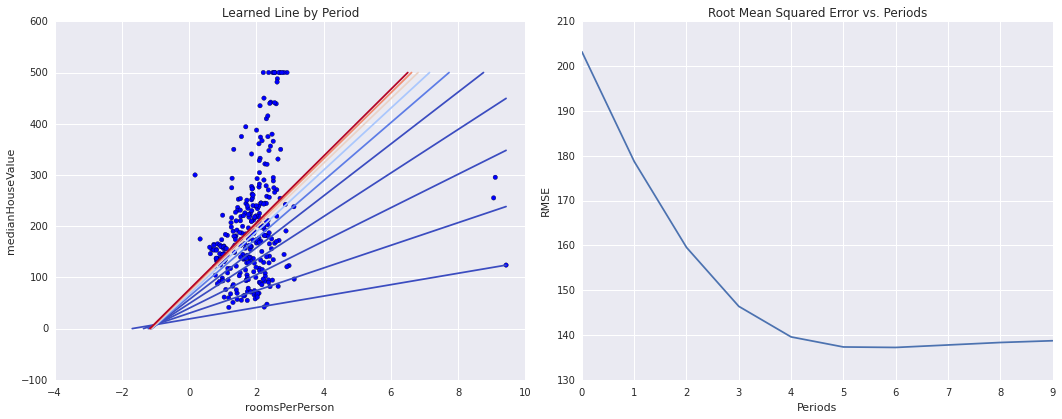

In [0]:
#@test {"skip": true}

LEARNING_RATE = 0.0005  #@param
STEPS = 50000  #@param
BATCH_SIZE = 5  #@param
periods = 10
steps_per_period = STEPS / periods

my_feature = "roomsPerPerson"

#
# Your code here
#



california_housing_dataframe[my_feature] = california_housing_dataframe["totalRooms"]/california_housing_dataframe["population"]

my_feature_column = california_housing_dataframe[my_feature]
my_label = "medianHouseValue"
targets = california_housing_dataframe[my_label]

# Create a linear regressor object.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  my_feature_column)
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=feature_columns,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Set up to plot the state of our model's line each period.
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Learned Line by Period")
plt.ylabel(my_label)
plt.xlabel(my_feature)
sample = california_housing_dataframe.sample(n=300)
plt.scatter(sample[my_feature], sample[my_label])
colors = [ cm.coolwarm(x) for x in linspace(-1, 1, periods) ]

# Train the model, but do so inside a loop so that we can periodically assess
# loss metrics.
print "Training model..."
print "RMSE (on training data):"
root_mean_squared_errors = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    my_feature_column,
    targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  # Take a break and compute predictions.
  predictions = linear_regressor.predict(my_feature_column)
  # Compute loss.
  root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(predictions, targets))
  # Occasionally print the current loss.
  print "  period %02d : %0.2f" % (period, root_mean_squared_error)
  # Add the loss metrics from this period to our list.
  root_mean_squared_errors.append(root_mean_squared_error)
  # Finally, track the weights and biases over time.
  # Apply some math to ensure that the data and line are plotted neatly.
  y_extents = np.array([0, sample[my_label].max()])
  x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
  x_extents = np.minimum(x_extents, sample[my_feature].max())
  y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
  plt.plot(x_extents, y_extents, color=colors[period])
print "Model training finished."

# Output a graph of loss metrics over periods.
plt.subplot(1, 2, 2)
plt.ylabel('RMSE')
plt.xlabel('Periods')
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
display.display(plt.plot(root_mean_squared_errors))

calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
display.display(calibration_data.describe())

print ("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 213.16
  period 01 : 190.92
  period 02 : 170.90
  period 03 : 154.10
  period 04 : 141.61
  period 05 : 134.47
  period 06 : 131.43
  period 07 : 130.25
  period 08 : 129.94
  period 09 : 129.89
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,194.1,207.3
std,56.4,116.0
min,48.7,15.0
25%,161.5,119.4
50%,192.9,180.4
75%,219.7,265.0
max,647.3,500.0


Final RMSE (on training data): 129.89


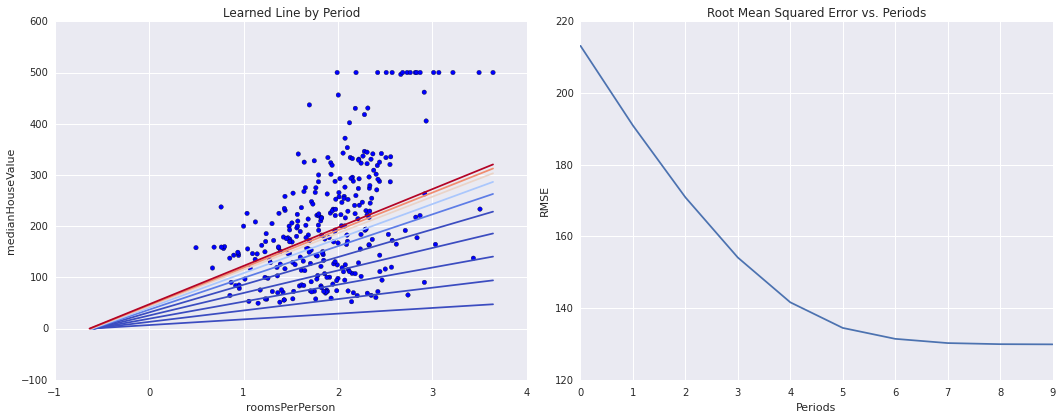

In [0]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore"}

LEARNING_RATE = 0.05
STEPS = 500
BATCH_SIZE = 5
periods = 10
steps_per_period = STEPS / periods

my_feature = "roomsPerPerson"


# Solution: We simply divide the two Series and store the result in a new column.
california_housing_dataframe[my_feature] = (
  california_housing_dataframe["totalRooms"] /
  california_housing_dataframe["population"])

my_feature_column = california_housing_dataframe[my_feature].apply(lambda x: min(x, 8))
my_label = "medianHouseValue"
targets = california_housing_dataframe[my_label]



# Create a linear regressor object.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  my_feature_column)
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=feature_columns,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Set up to plot the state of our model's line each period.
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Learned Line by Period")
plt.ylabel(my_label)
plt.xlabel(my_feature)
sample = california_housing_dataframe.sample(n=300)
plt.scatter(sample[my_feature], sample[my_label])
colors = [ cm.coolwarm(x) for x in linspace(-1, 1, periods) ]

# Train the model, but do so inside a loop so that we can periodically assess
# loss metrics.
print "Training model..."
print "RMSE (on training data):"
root_mean_squared_errors = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    my_feature_column,
    targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  # Take a break and compute predictions.
  predictions = linear_regressor.predict(my_feature_column)
  # Compute loss.
  root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(predictions, targets))
  # Occasionally print the current loss.
  print "  period %02d : %0.2f" % (period, root_mean_squared_error)
  # Add the loss metrics from this period to our list.
  root_mean_squared_errors.append(root_mean_squared_error)
  # Finally, track the weights and biases over time.
  # Apply some math to ensure that the data and line are plotted neatly.
  y_extents = np.array([0, sample[my_label].max()])
  x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
  x_extents = np.minimum(x_extents, sample[my_feature].max())
  y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
  plt.plot(x_extents, y_extents, color=colors[period])
print "Model training finished."

# Output a graph of loss metrics over periods.
plt.subplot(1, 2, 2)
plt.ylabel('RMSE')
plt.xlabel('Periods')
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
display.display(plt.plot(root_mean_squared_errors))

calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
display.display(calibration_data.describe())

print ("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

### Task 2: Identify outliers.

We can visualize the performance of our model by creating a scatter plot of predictions vs. target values.  Ideally, these would lie on a perfectly correlated diagonal line.

Use `plt.scatter()` to create a scatter plot of predictions vs. targets, using the rooms per person model you trained in Task 1.

Do you see any oddities?  Trace these back to their root by looking at the distribution of values in `roomsPerPerson`.

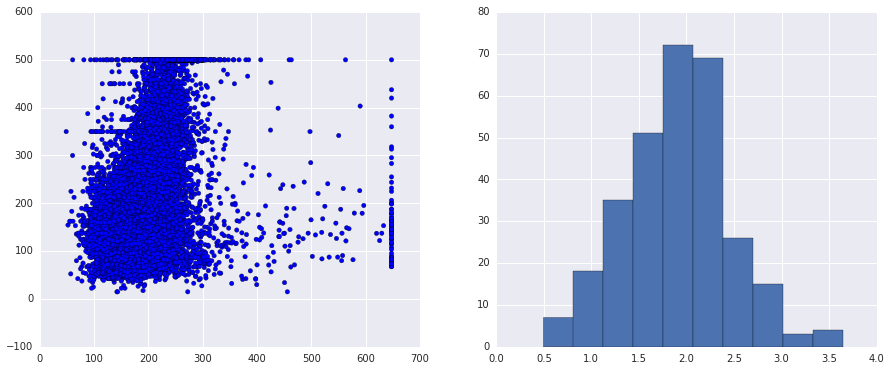

In [12]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore"}

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.subplot(1, 2, 2)
sample["roomsPerPerson"].hist()

### Task 3: Clip outliers.

See if you can improve model fit further by setting outlier values of `roomsPerPerson` to some sane minimum or maximum.

For reference, here's a quick example of how to apply a function to a pandas series:

    clipped_feature = my_feature_column["myFeatureName"].apply(lambda x: max(x, 0))

The above `clipped_feature` will have no values less than `0`.

### Task 3: Clip outliers.

See if you can improve model fit further by setting outlier values of `roomsPerPerson` to some sane minimum or maximum.

For reference, here's a quick example of how to apply a function to a pandas series:

    clipped_feature = my_feature_column["myFeatureName"].apply(lambda x: max(x, 0))

The above `clipped_feature` will have no values less than `0`.

Training model...
RMSE (on training data):
  period 00 : 213.26
  period 01 : 191.01
  period 02 : 170.82
  period 03 : 153.65
  period 04 : 140.59
  period 05 : 132.84
  period 06 : 129.31
  period 07 : 127.76
  period 08 : 127.24
  period 09 : 127.01
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,192.9,207.3
std,49.2,116.0
min,48.7,15.0
25%,161.5,119.4
50%,192.9,180.4
75%,219.7,265.0
max,422.3,500.0


Final RMSE (on training data): 127.01


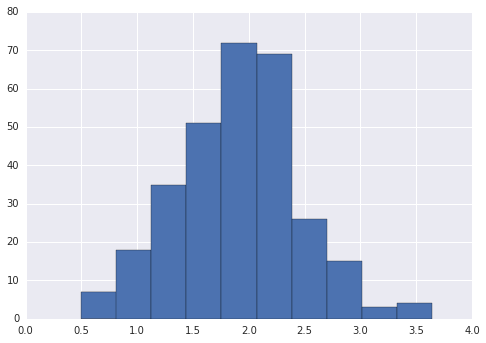

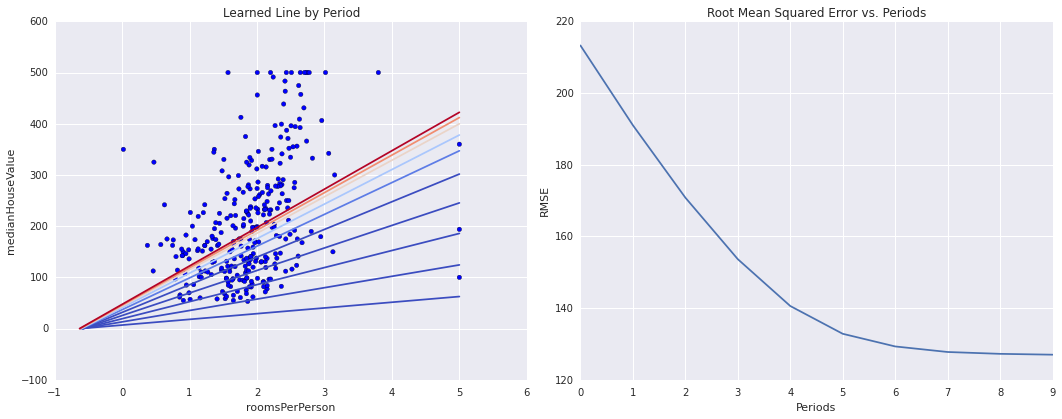

In [0]:
#@title To view a possible solution, toggle Form

#@test {"output": "ignore"}

LEARNING_RATE = 0.05
STEPS = 500
BATCH_SIZE = 5
periods = 10
steps_per_period = STEPS / periods

my_feature = "roomsPerPerson"

# Build the synthetic feature that we've previously created.
california_housing_dataframe[my_feature] = (
  california_housing_dataframe["totalRooms"] /
  california_housing_dataframe["population"])

# Solution: the histogram shows that the majority of the values are less than 5.
# So let's remove the outliers by clipping.
california_housing_dataframe[my_feature] = (
  california_housing_dataframe[my_feature].apply(lambda x: min(x, 5)))

# Double check the results of clipping.
sample[my_feature].hist()
plt.figure()

my_feature_column = california_housing_dataframe[my_feature]
my_label = "medianHouseValue"
targets = california_housing_dataframe[my_label]

# Create a linear regressor object.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  my_feature_column)
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=feature_columns,
  optimizer=tf.GradientDescentOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Set up to plot the state of our model's line each period.
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Learned Line by Period")
plt.ylabel(my_label)
plt.xlabel(my_feature)
sample = california_housing_dataframe.sample(n=300)
plt.scatter(sample[my_feature], sample[my_label])
colors = [ cm.coolwarm(x) for x in linspace(-1, 1, periods) ]

# Train the model, but do so inside a loop so that we can periodically assess
# loss metrics.
print "Training model..."
print "RMSE (on training data):"
root_mean_squared_errors = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    my_feature_column,
    targets,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  # Take a break and compute predictions.
  predictions = linear_regressor.predict(my_feature_column)
  # Compute loss.
  root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(predictions, targets))
  # Occasionally print the current loss.
  print "  period %02d : %0.2f" % (period, root_mean_squared_error)
  # Add the loss metrics from this period to our list.
  root_mean_squared_errors.append(root_mean_squared_error)
  # Finally, track the weights and biases over time.
  # Apply some math to ensure that the data and line are plotted neatly.
  y_extents = np.array([0, sample[my_label].max()])
  x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
  x_extents = np.minimum(x_extents, sample[my_feature].max())
  y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
  plt.plot(x_extents, y_extents, color=colors[period])
print "Model training finished."

# Output a graph of loss metrics over periods.
plt.subplot(1, 2, 2)
plt.ylabel('RMSE')
plt.xlabel('Periods')
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
display.display(plt.plot(root_mean_squared_errors))

calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
display.display(calibration_data.describe())

print ("Final RMSE (on training data): %0.2f" % root_mean_squared_error)